<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.S50x Course Team, Copyright 2021 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# RECITATION 5: Matched Filtering

<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 5.0 Overview of Learning Objectives

In this recitation we will explore the following objectives:

- What is matched filtering?
- Matched filtering in the time domain
- Matched filtering in the frequency domain

<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 5.1 What is matched filtering?

The purpose of matched filtering is to scan big data sets looking for some kind of signal. LIGO does this to look for gravitational waves in their strain data. Matched filtering is also done in many other fields.

The purpose is usually to create some kind of plot of signal to noise ratio (SNR) over your data. For LIGO, this is a 2D plot with time on the x axis and SNR on the y axis. If you're looking for point sources in astrophysical telescope data, for example, this is an image plot with right ascention and declination as the axes and SNR shown in the image.

Signals look like large spikes in the SNR.

<!--end-block-->

<!--start-block-->
#### <span style="color:green">>>>RUN</span>

To make this exercise useful to you in the LIGO project, we'll make a model signal that looks kind of like a black hole waveform. Run the below code to load the waveform and plot an example. (This is nearly the same function as was used in recitation 3)

<!--
#initial code
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0x98a09fe)

def complicated_model_fn(x, time, lambda_plus, lambda_minus, max_amp, omega_0, omega_max, omega_sigma):
    omega = (omega_max - omega_0) * (np.exp(-np.minimum(x - time, 0)**2 / omega_sigma)) + omega_0
    lambdas = np.array([lambda_plus if xvalue > time else lambda_minus for xvalue in x])
    amplitude = max_amp * np.exp(-abs(x - time) / lambdas)
    return amplitude * np.cos(omega * (x-time))

LAMBDA_PLUS_TRUE = 1.0
LAMBDA_MINUS_TRUE = 4
MAX_AMP_TRUE = 1.2
OMEGA_0_TRUE = 3.0
OMEGA_MAX_TRUE = 6.0
OMEGA_SIGMA_TRUE = 4.0
TIME_TRUE = 0.0

xi = np.linspace(TIME_TRUE-15, TIME_TRUE+5, 200)
true_yi = complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

plt.plot(xi, true_yi)
plt.xlabel("Time (s)")
plt.ylabel("Strain");
-->

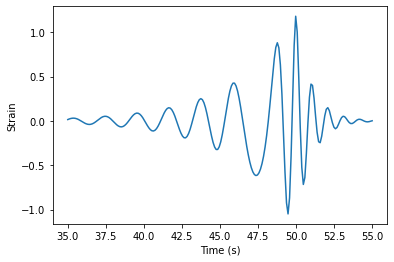

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0x98a09fe)

def complicated_model_fn(x, time, lambda_plus, lambda_minus, max_amp, omega_0, omega_max, omega_sigma):
    omega = (omega_max - omega_0) * (np.exp(-np.minimum(x - time, 0)**2 / omega_sigma)) + omega_0
    lambdas = np.array([lambda_plus if xvalue > time else lambda_minus for xvalue in x])
    amplitude = max_amp * np.exp(-abs(x - time) / lambdas)
    return amplitude * np.cos(omega * (x-time))

LAMBDA_PLUS_TRUE = 1.0
LAMBDA_MINUS_TRUE = 4
MAX_AMP_TRUE = 1.2
OMEGA_0_TRUE = 3.0
OMEGA_MAX_TRUE = 6.0
OMEGA_SIGMA_TRUE = 4.0
TIME_TRUE = 50.0

xi = np.linspace(TIME_TRUE-15, TIME_TRUE+5, 200)
true_yi = complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

plt.plot(xi, true_yi)
plt.xlabel("Time (s)")
plt.ylabel("Strain");

<!--start-block-->
#### <span style="color:green">>>>RUN</span>

Let's make some fake data. We'll simulate "noise" as ten sinusoids of varying frequency, phase, and amplitude added together, and superimpose a merger signal at $t=0$.

<!--
#initial code
NUMBER_SINES_TO_ADD = 10

noise_frequencies = 0.5 + 7 * np.random.random(NUMBER_SINES_TO_ADD)
noise_phases = 2 * np.pi * np.random.random(NUMBER_SINES_TO_ADD)
noise_amplitudes = 2 * MAX_AMP_TRUE / NUMBER_SINES_TO_ADD * np.random.random(NUMBER_SINES_TO_ADD)
    # The above line sets noise amplitudes so that the sum of all the noise amplitudes is on average
    # equal to the maximum amplitude of the signal.

sample_spacing = 0.1
xi = np.arange(-128, 128, sample_spacing)#times
yi = np.zeros_like(xi)#data

for freq, phase, amplitude in zip(noise_frequencies, noise_phases, noise_amplitudes):
    yi += amplitude * np.sin(phase + freq * xi)
    
yi += complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

plt.figure(figsize=(16, 5))
plt.plot(xi, yi)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
-->

Text(0, 0.5, 'Strain')

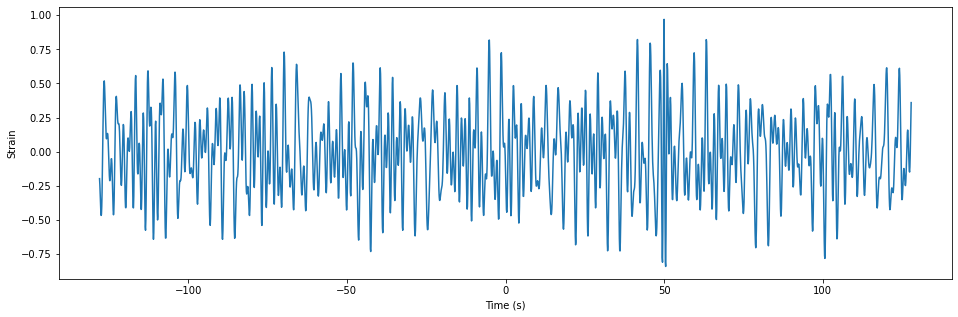

In [2]:
NUMBER_SINES_TO_ADD = 10

noise_frequencies = 0.5 + 7 * np.random.random(NUMBER_SINES_TO_ADD)
noise_phases = 2 * np.pi * np.random.random(NUMBER_SINES_TO_ADD)
noise_amplitudes = 2 * MAX_AMP_TRUE / NUMBER_SINES_TO_ADD * np.random.random(NUMBER_SINES_TO_ADD)
    # The above line sets noise amplitudes so that the sum of all the noise amplitudes is on average
    # equal to the maximum amplitude of the signal.

sample_spacing = 0.1
xi = np.arange(-128, 128, sample_spacing)#times
yi = np.zeros_like(xi)#data

for freq, phase, amplitude in zip(noise_frequencies, noise_phases, noise_amplitudes):
    yi += amplitude * np.sin(phase + freq * xi)
    
yi += complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

plt.figure(figsize=(16, 5))
plt.plot(xi, yi)
plt.xlabel("Time (s)")
plt.ylabel("Strain")

<!--start-block-->

Our goal is to find the signal in this data.

<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 5.2 Time domain

Matched filtering in the time domain is probably conceptually the easiest approach to matched filtering. We will perform a fit of the model function to the data, forcing the model function to assume a time of merger of $t$, then plot the quality of the fit as a function of $t$. We expect a very good fit quality when $t$ is close to the true time $t=0$, and otherwise we expect poor fits.

<!--end-block-->

<!--start-block-->
#### <span style="color:#BA2220">>>>EXERCISE</span>

We'll need to cut the data to perform the fit. How much time before and after $t$ would you like to fit over?

<!--
#initial code
t_before = #your code here
t_after = #your code here
-->

<!--
#solution
t_before = 5
t_after = 2
-->

<!--end-block-->

In [4]:
t_before = 1
t_after = 1

<!--start-block-->
#### <span style="color:#BA2220">>>>EXERCISE</span>

Make a function that creates `LMFIT` `Model` and `Parameters` instance, forcing the time of the signal to appear at time $t$. Seed the starting points of parameters randomly. Refer to recitation 3 code if you need help.

Restrict your `time` parameter to be exactly $t$ by setting its `value` equal to $t$ and setting `vary=False`

<!--
#initial code
from lmfit import Model, Parameters
    
params_min_max = {
    'lambda_plus': (0.1, 5),
    'lambda_minus': (0.1, 5),
    'max_amp': (0, 2),
    'omega_0': (0, 5),
    'omega_max': (0, 10),
    'omega_sigma': (0, 5)
}

def model_and_random_parameters(t, delta_t):
    #your code here
-->

<!--
#solution
from lmfit import Model, Parameters

params_min_max = {
    'lambda_plus': (0.1, 5),
    'lambda_minus': (0.1, 5),
    'max_amp': (0, 2),
    'omega_0': (0, 5),
    'omega_max': (0, 10),
    'omega_sigma': (0, 5),
}

def model_and_random_parameters(t):
    model = Model(complicated_model_fn)
    params = Parameters()
    params.add('time', value=t, vary=False)
    for p, (p_min, p_max) in params_min_max.items():
        value = p_min + (p_max - p_min) * np.random.random(1)
        params.add(p, min=p_min, max=p_max, value=value)
    return model, params
-->

<!--end-block-->

In [5]:
from lmfit import Model, Parameters
    
params_min_max = {
    'lambda_plus': (0.1, 5),
    'lambda_minus': (0.1, 5),
    'max_amp': (0, 2),
    'omega_0': (0, 5),
    'omega_max': (0, 10),
    'omega_sigma': (0, 5)
}

def model_and_random_parameters(t, delta_t):
    model = Model(complicated_model_fn)
    params = Parameters()
    params.add('time',value=t,vary=False)
    for p, (p_min,p_max) in params_min_max.items():
        value = p_min + (p_max-p_min)*np.random.random(1)
        params.add(p,min=p_min,max=p_max,value=value)
    return model, params

<!--start-block-->
#### <span style="color:green">>>>RUN</span>

This function cuts the data to data around $t$ and performs a fit, using your `model_and_random_parameters` function.

<!--
#initial code
def fit_once(t):
    data_indices = np.where((xi > t - t_before) & (xi < t + t_after))
    data_x = xi[data_indices]
    data_y = yi[data_indices]
    model, params = model_and_random_parameters(t)
    result = model.fit(data_y, params, x=data_x)
    return result
-->

<!--end-block-->

In [6]:
def fit_once(t):
    data_indices = np.where((xi > t - t_before) & (xi < t + t_after))
    data_x = xi[data_indices]
    data_y = yi[data_indices]
    model, params = model_and_random_parameters(t,1)
    result = model.fit(data_y, params, x=data_x)
    return result

<!--start-block-->
#### <span style="color:#BA2220">>>>EXERCISE</span>

Call `fit_once` at $t=0$. We would hope the result succeeds, since the waveform was inserted into the data at $t=0$. However, it doesn't always in practice.

<!--
#initial code
#your code here
-->

<!--
#solution
result = fit_once(TIME_TRUE)
print(result.fit_report())
result.plot();
-->

<!--end-block-->

In [7]:
fit_once(0)

<!--start-block-->
#### <span style="color:green">>>>RUN</span>

Instead of `fit_once`, we'll use a new function called `fit`, which runs `fit_once` multiple times and takes the best result.
<!--
#initial code
from multiprocessing import Pool

NUM_FITS = 6

def fit(t, pool):
    results = pool.map(fit_once, np.full(NUM_FITS, t))
    min_result = None
    min_chisq = None
    for result in results:
        if min_chisq is None or min_chisq > result.chisqr:
            min_result = result
            min_chisq = result.chisqr
    return min_result

with Pool(6) as pool:
    result = fit(TIME_TRUE, pool)
print(result.fit_report())
result.plot();
-->

<!--end-block-->

In [8]:
NUM_FITS = 6
def fit(t):
    results = [fit_once(t) for t in np.full(NUM_FITS,t)]
    min_result = None
    min_chisq = None
    for result in results:
        if min_chisq is None or min_chisq > result.chisqr:
            min_result = result
            min_chisq = result.chisqr
    return min_result

<!--start-block-->
#### <span style="color:#BA2220">>>>EXERCISE</span>

Call `fit` for values of $t \in [-100, 100]$, where the $t$ values are separated by $\Delta t \sim 1 \text{s}$. Store the results in an array named `results`. This may take a while.


<!--
#initial code
results = []
delta_t = 1
ts = np.arange(-10, 10, delta_t)

#your code here
-->

<!--
#solution
results = []
delta_t = 1
ts = np.arange(-100, 100, delta_t)

with Pool(NUM_F|ITS) as pool:
    for t in ts:
        if t % 10 == 0: print(t)
        results.append(fit(t, pool))
-->

<!--end-block-->

In [9]:
results = []
delta_t = 1
ts = np.arange(-100, 100, delta_t)

#your code here
for t in ts:
    if t%5==0:
        print(t)
        results.append(fit(t))


-100
-95
-90
-85
-80
-75
-70
-65
-60
-55
-50
-45
-40
-35
-30
-25
-20
-15
-10
-5
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


<!--start-block-->
#### <span style="color:#BA2220">>>>EXERCISE</span>

Choose some number which represents the success of the fit and plot it as a function of $t$ given the `results` you just calculated.

<!--
#initial code
#your code here
-->

<!--
#solution
amps = [r.params["max_amp"].value for r in results]
plt.plot(ts, amps)
plt.xlabel("Time(s)")
plt.ylabel("Wave amplitudes (SNR)")
-->

<!--end-block-->

In [10]:
tss = [5*i-100 for i in range(40)]
print(tss)

[-100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


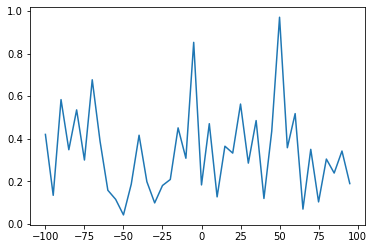

In [58]:
#your code here
amps = [r.params["max_amp"] for r in results]
plt.plot(tss,amps)

<!--start-block-->
#### <span style="color:purple">>>>QUESTION</span>

This took a while to run. But in practice, it's nice to have searches like this run quickly, so that if a wave event is detected, an alert can be sent out to telescopes all over the world and they can look at the correct area of the sky with minimal delay.

How could you make this process faster, aside from running it on better hardware?

<!--
#solution
- Constrain parameters of the model to realistic values so that you're fitting with fewer degrees of freedom
- Delve into the minimization software and tell it to halt if it's detecting a chi squared value above a certain threshold. Don't bother to minimize all the way to the maximum chi squared if you already know it's going to be significant
- Don't perform a full fit; compare to some template or set of templates and plot the chi squared
- Don't use the time domain! (see below)
-->


<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 5.3 Frequency domain

Now we're going to do a similar process in the frequency domain, but instead of performing a fit, we're going compare the data to a template merger which we will generate.

<!--end-block-->

<!--start-block-->
#### <span style="color:green">>>>RUN</span>

Let's start by making the template in the time domain. The parameters will be similar to the true values, but slightly off.
<!--
#initial code
yi_temp = complicated_model_fn(xi, 0, 1.5, 3.5, 1.0, 3.2, 5.5, 3.5)
yi_true = complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

template_mask = np.where((xi > -15) & (xi < 5))
data_mask = np.where((xi > TIME_TRUE-15) & (xi < TIME_TRUE+5))
plt.plot(xi[data_mask]-TIME_TRUE, yi_true[data_mask], label="True")
plt.plot(xi[template_mask], yi_temp[template_mask], label="Template")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend();
-->

<!--end-block-->

In [ ]:
yi_temp = complicated_model_fn(xi, 0, 1.5, 3.5, 1.0, 3.2, 5.5, 3.5)
yi_true = complicated_model_fn(xi, TIME_TRUE, LAMBDA_PLUS_TRUE, LAMBDA_MINUS_TRUE, MAX_AMP_TRUE,
                               OMEGA_0_TRUE, OMEGA_MAX_TRUE, OMEGA_SIGMA_TRUE)

template_mask = np.where((xi > -15) & (xi < 5))
data_mask = np.where((xi > TIME_TRUE-15) & (xi < TIME_TRUE+5))
plt.plot(xi[data_mask]-TIME_TRUE, yi_true[data_mask], label="True")
plt.plot(xi[template_mask], yi_temp[template_mask], label="Template")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend();

<!--start-block-->
#### <span style="color:green">>>>RUN</span>

We're going to be working in the frequency domain, so start by fft-ing our template and data.

<!--
#initial code
import matplotlib.pyplot as plt

fs = int(1/(xi[1] - xi[0]))

data_fft = np.fft.fft(yi)
template_fft = np.fft.fft(yi_temp)

freq = np.fft.fftfreq(xi.shape[0])*fs

#template_fft *= np.exp(-1.0j * 50 * freq * 2 * np.pi)

plt.figure(figsize=(16, 5))
plt.plot(freq, data_fft.real)
plt.plot(freq, data_fft.imag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.ylim(-20, 20)

plt.figure(figsize=(16, 5))
plt.plot(freq, template_fft.real)
plt.plot(freq, template_fft.imag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.ylim(-20, 20)
-->

<!--end-block-->

In [ ]:
import matplotlib.pyplot as plt

fs = int(1/(xi[1] - xi[0]))

data_fft = np.fft.fft(yi)
template_fft = np.fft.fft(yi_temp)

freq = np.fft.fftfreq(xi.shape[0])*fs

#template_fft *= np.exp(-1.0j * 50 * freq * 2 * np.pi)

plt.figure(figsize=(16, 5))
plt.plot(freq, data_fft.real)
plt.plot(freq, data_fft.imag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.ylim(-20, 20)

plt.figure(figsize=(16, 5))
plt.plot(freq, template_fft.real)
plt.plot(freq, template_fft.imag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.ylim(-20, 20)

<!--start-block-->
Now suppose we want to do the same thing we did in the time domain case: shift the template by a time $t$. What happens to the FFT? Consider the integral definition of a fourier transform (as a substitute for the discrete case):

$$\mathcal{F}(\omega) = \int dt f(t)  e^{-2\pi i\omega t}$$

So the FFT for a function shifted by $\Delta t$ is

$$\int dt f(t - \Delta t)  e^{-2\pi i\omega t} = \int dt' f(t')  e^{-2\pi i\omega (t'+\Delta t)} = e^{-2\pi i \omega \Delta t}\mathcal{F}(\omega).$$

It's just a multiplicative factor times the initial template FFT!

<!--end-block-->

<!--start-block-->
So suppose our data is indeed just our template, shifted by some time $\Delta t$. We can recover $\Delta t$ from the data FFT $\mathcal{D}$ and the template FFT $\mathcal{T}$ by

$$\mathcal{D}(\omega)=e^{-2\pi i\omega \Delta t} \mathcal{T}(\omega) \implies \frac{\mathcal{D}(\omega)}{\mathcal{T}(\omega)}=e^{-2\pi i\omega \Delta t} = \frac{\mathcal{D}(\omega) \mathcal{T}^*(\omega)}{|\mathcal{T}|^2(\omega)}.$$

Take the inverse Fourier transform of this ratio and you get a delta function at $\Delta t$:

$$f(t) = \int d\omega e^{-2\pi i\omega \Delta t} e^{2\pi i\omega t} = \delta(\Delta t - t).$$

In other words, the peak of the IFFT of 
$$f(\omega) =\mathcal{D}(\omega) \mathcal{T}^*(\omega)$$
is centered on $\Delta t$.

There's some extra complication behind this, but above is the gist. For more information, see the [LIGO tutorial from which this code is inspired](https://www.gw-openscience.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html).

<!--end-block-->

<!--start-block-->
#### <span style="color:green">>>>RUN</span>

Let's compute $f(\omega)$ as written above, using the power spectral density of the data instead of $|\mathcal{T}|^2$ in the numerator. We call it `optimal_fft`. Then we take the IFFT and call it `optimal_time`.

<!--
#initial code
power_data, freq_psd = plt.psd(yi, Fs=fs, NFFT=4 * fs)
power_vec = np.interp(freq, freq_psd, power_data)

optimal_fft = data_fft * template_fft.conjugate() / power_vec

optimal_time = 2*np.fft.ifft(optimal_fft)*fs
optimal_time_xi = np.append(xi[len(xi)//2:], xi[:len(xi)//2])
-->

<!--end-block-->

In [ ]:
power_data, freq_psd = plt.psd(yi, Fs=fs, NFFT=4 * fs)
power_vec = np.interp(freq, freq_psd, power_data)

optimal_fft = data_fft * template_fft.conjugate() / power_vec

optimal_time = 2*np.fft.ifft(optimal_fft)*fs
optimal_time_xi = np.append(xi[len(xi)//2:], xi[:len(xi)//2])

<!--start-block-->
#### <span style="color:green">>>>RUN</span>

We should really plot some sort of signal to noise ratio, not `optimal_time` itself. Let's fix the ratio so that if the data is just noise, we have a ratio of one. We record the ratio as `SNR` and plot it.
<!--
#initial code
df = np.abs(freq[1] - freq[0])
sigmasq = 2*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

plt.figure()
plt.plot(optimal_time_xi, SNR)
plt.xlabel('Offset time (s)')
plt.ylabel('SNR');
-->

<!--end-block-->

In [ ]:
df = np.abs(freq[1] - freq[0])
sigmasq = 2*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

plt.figure()
plt.plot(optimal_time_xi, SNR)
plt.xlabel('Offset time (s)')
plt.ylabel('SNR');

<!--start-block-->
#### <span style="color:purple">>>>QUESTION</span>

Change the data, perhaps by adding more noise or a different kind of noise, or by shifting the signal to a different time. What changes in the matched filter result?

<!--
#solution
The max filter peak should track the time of the event
-->

<!--end-block-->

<!--start-block-->
#### <span style="color:purple">>>>QUESTION</span>

The runtime of the frequency domain matched filtering process was much faster than the time domain process. But we should not compare the directly because we tested against a template for the frequency version and performed a whole fit for the time version.

If we instead used a template for the time version as well, computing a $\chi^2$ for every offset $t$ between the signal and the template and plotted $\chi^2$ as a function of $t$, which method do you think would be faster now? Frequency or time?

<!--
#solution
Still frequency. If the template is $m$ long and the data is $n$ long, the time domain has complexity $O(mn)$, since it must spend $m$ operations computing a $\chi^2$ for each of the $n$ data points.

The frequency domain computes an $O(n\log n)$ and $O(m\log m)$ fft, then computes the product of the data and template ffts in $O(n)$ time. That's faster than the time case.
-->

<!--end-block-->